# Investigate alleles that increased abundance

Almost all variants with abundance changes that surpass assay variability are decreases in abundance. For the very few cases that increased abundance, we want to see if there is anything biologically interesting going on here.

In [4]:
import polars as pl
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append("../..")
from utils import *

In [2]:
outputs_dir = "../3_outputs"

## 1. Variants with increased abundance

In [3]:
scores = pl.read_csv(f"{outputs_dir}/DUALIPA_median_zscore.csv", infer_schema_length=1000000)
incr_abun = scores.filter(pl.col("zscore_log2") > 1.96)
print(incr_abun.select(['symbol', 'aa_change', 'zscore_log2', 'clinvar_clnsig_clean', 'StarStatus']))

shape: (20, 5)
┌────────┬───────────┬─────────────┬──────────────────────┬────────────┐
│ symbol ┆ aa_change ┆ zscore_log2 ┆ clinvar_clnsig_clean ┆ StarStatus │
│ ---    ┆ ---       ┆ ---         ┆ ---                  ┆ ---        │
│ str    ┆ str       ┆ f64         ┆ str                  ┆ i64        │
╞════════╪═══════════╪═════════════╪══════════════════════╪════════════╡
│ SH3BP2 ┆ Gly420Arg ┆ 2.586043    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Pro151Leu ┆ 3.18631     ┆ 4_VUS                ┆ 1          │
│ KLHL3  ┆ Glu85Ala  ┆ 3.787192    ┆ 1_Pathogenic         ┆ null       │
│ KLHL3  ┆ Ala77Glu  ┆ 3.687362    ┆ 1_Pathogenic         ┆ null       │
│ ALAS2  ┆ Ile439Asn ┆ 2.014362    ┆ 1_Pathogenic         ┆ null       │
│ …      ┆ …         ┆ …           ┆ …                    ┆ …          │
│ PKP2   ┆ Thr263Met ┆ 2.034165    ┆ 4_VUS                ┆ 2          │
│ SH3BP2 ┆ Pro418Leu ┆ 2.758718    ┆ 1_Pathogenic         ┆ 2          │
│ KLHL3  ┆ Met78Val  ┆ 2.264252    ┆

## 2. Group the variants by gene

In [22]:
symbol_medians = scores.filter(~pl.col("zscore_log2").is_null()).group_by("symbol").agg(
    pl.col("zscore_log2").median().alias("median_log2")
).sort("median_log2")

symbol_order = symbol_medians.select('symbol').to_series().to_list()

scores_plot = scores.join(symbol_medians, on="symbol").to_pandas()
scores_plot['symbol'] = pd.Categorical(scores_plot['symbol'], categories=symbol_order, ordered=True)
scores_plot

,symbol,node_type,nt_change,aa_change,pla,well,coordinates,n_cells,orf_id,mut_id,...,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp,median_log2
0,KCNJ2,allele,821A>T,Asp274Val,11,H06,11_H06,4976,100016069.0,2638.0,...,None,None,None,None,None,None,None,None,None,-5.711906
1,PKP2,allele,1415A>G,Lys472Arg,19,F05,19_F05,2900,54308.0,3072.0,...,None,None,None,None,None,None,None,None,None,-0.030817
2,KCNJ2,allele,899G>A,Gly300Asp,11,D07,11_D07,8822,100016069.0,2641.0,...,None,None,None,None,None,None,None,None,None,-5.711906
3,HBD,allele,174C>A,Asn58Lys,26,E05,26_E05,9609,13796.0,218146.0,...,None,None,None,None,None,None,None,None,None,-5.538215
4,SMAD3,allele,376C>T,His126Tyr,20,H03,20_H03,9096,11805.0,2128.0,...,None,None,None,None,None,None,None,None,None,-0.965726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,DCX,allele,232C>T,Arg78Cys,8,B05,8_B05,7141,8416.0,216626.0,...,None,None,None,None,None,None,None,None,None,-0.550922
1046,ALAS2,allele,1591A>G,Ser531Gly,4,G10,4_G10,10913,8420.0,216668.0,...,None,None,None,None,None,None,None,None,None,-0.188377
1047,STXBP1,allele,1217G>A,Arg406His,13,A09,13_A09,4229,7652.0,1827.0,...,None,None,None,None,None,None,None,None,None,-4.589170
1048,GFAP,allele,1157A>T,Asn386Ile,26,A11,26_A11,1714,2920.0,214447.0,...,None,None,None,None,None,None,None,None,None,-2.801866


<Figure size 640x480 with 0 Axes>

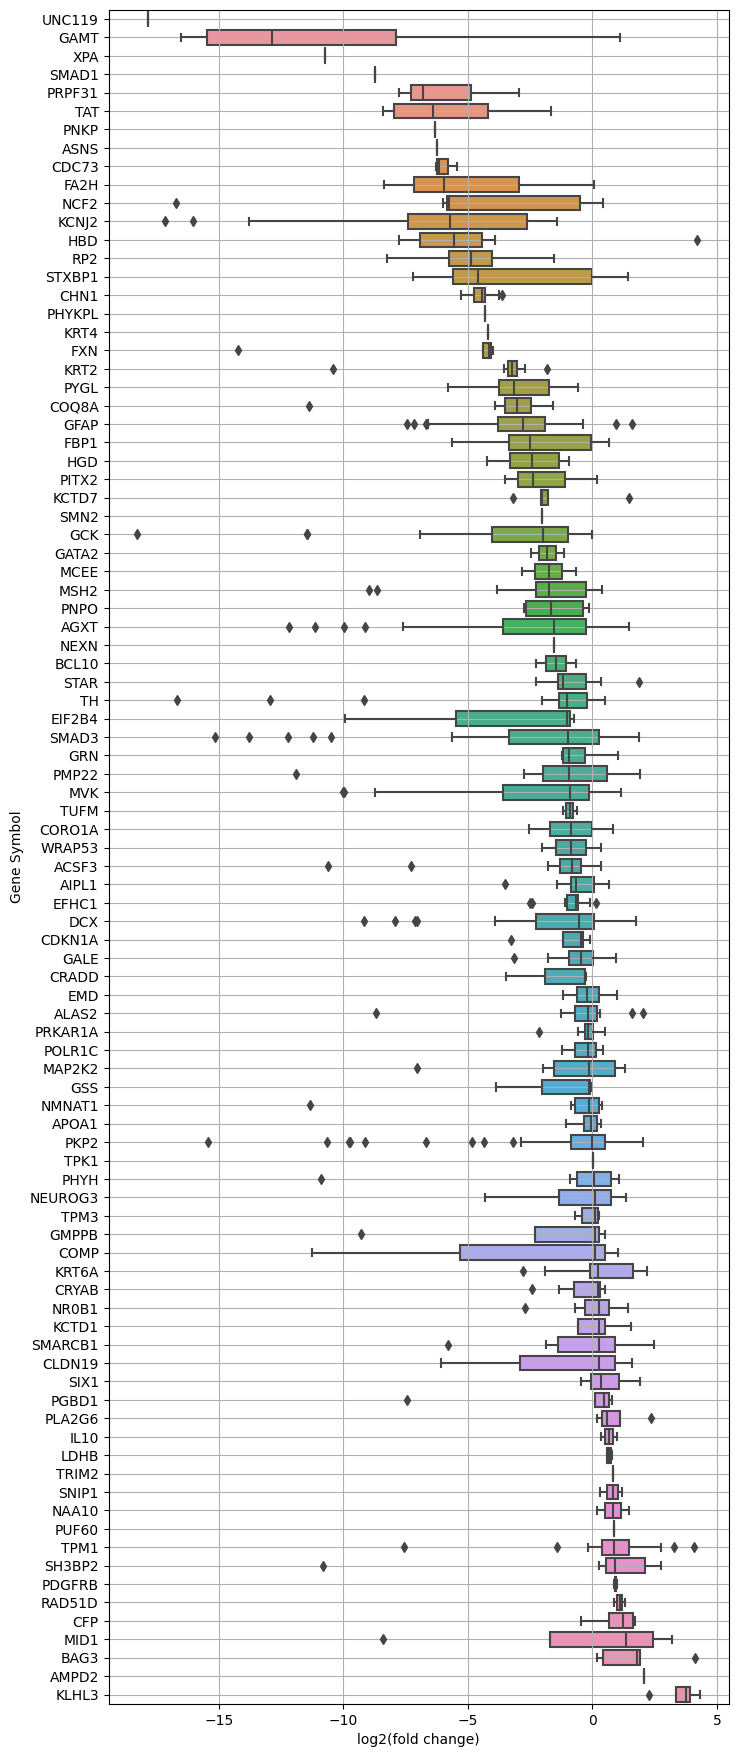

In [6]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 22))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", ax=ax)
ax.set_xlabel("log2(fold change)")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

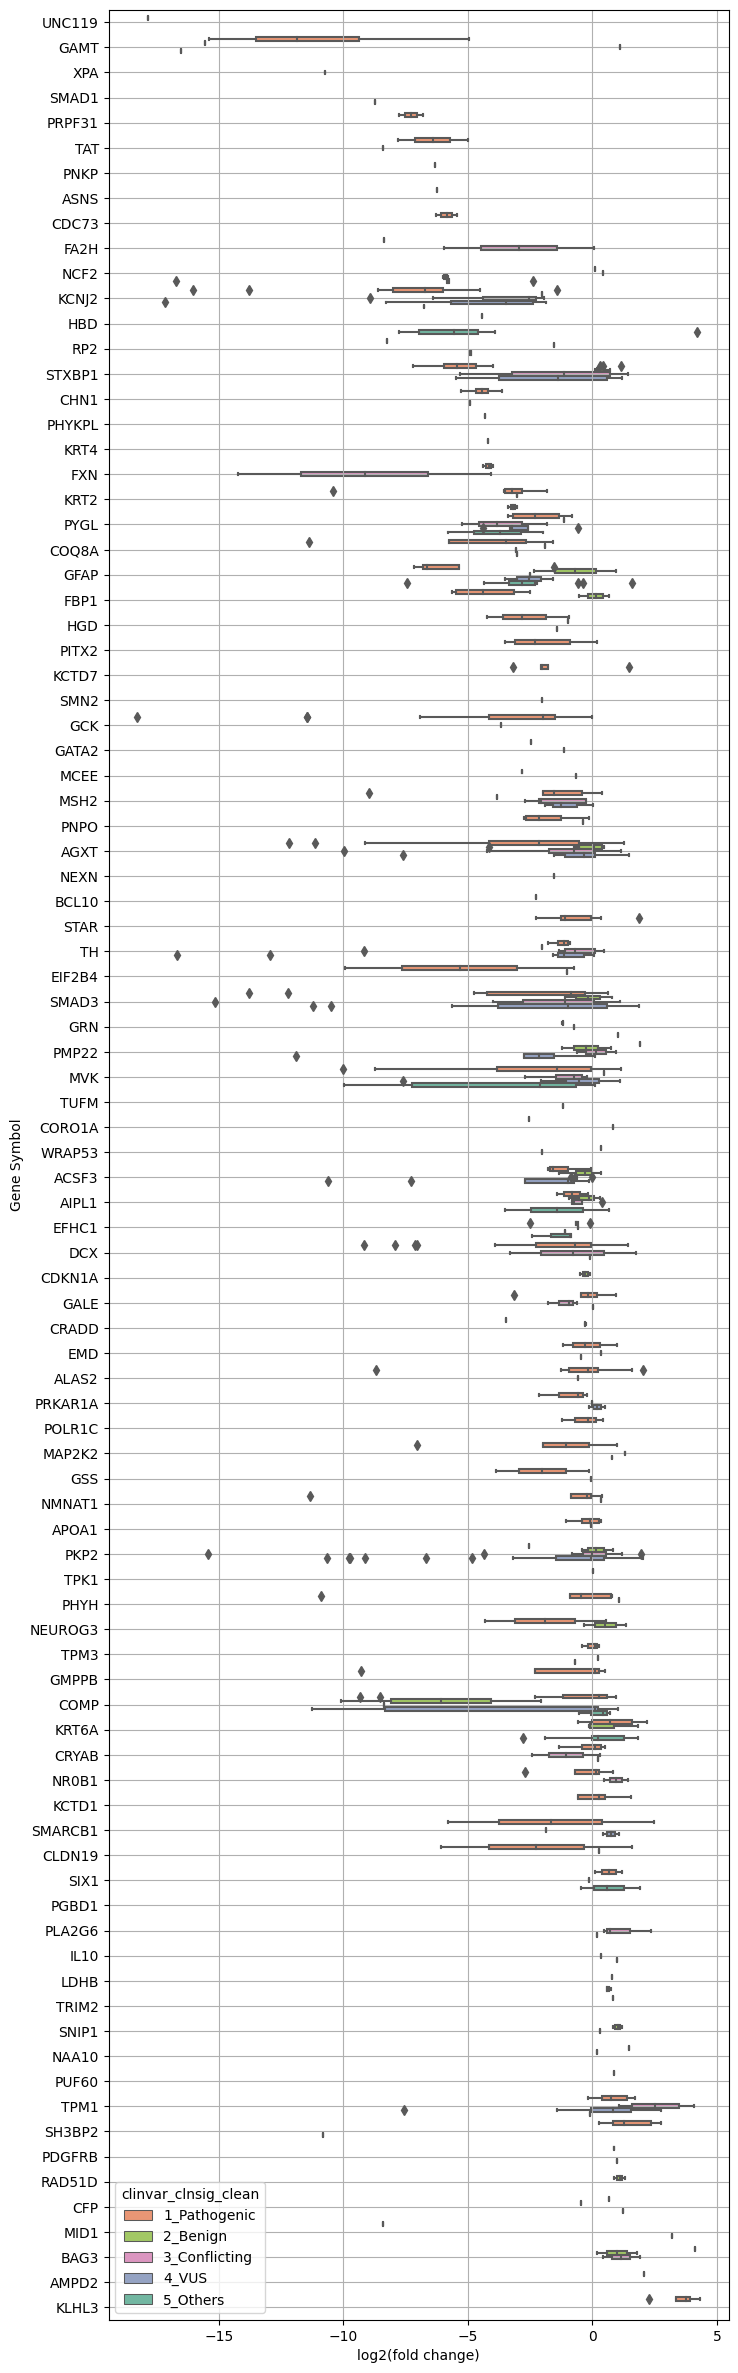

In [8]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 30))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", 
            palette=palette_dict["clinvar_clnsig_clean"], ax=ax, 
            hue="clinvar_clnsig_clean", 
            hue_order=sorted(scores_plot.dropna(subset="clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
           )
ax.set_xlabel("log2(fold change)")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

## 3. Map with Pillar Project

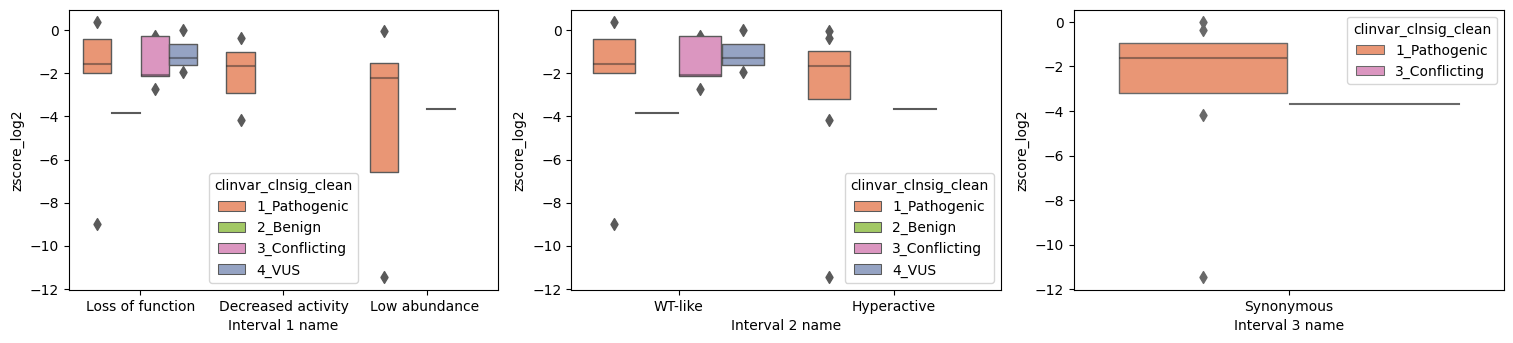

In [33]:
func_scores = scores.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

fig, axes = plt.subplots(2, 4, figsize=(25,8))
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.boxenplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y="zscore_log2",
            ax=axes.flatten()[i-1],
            palette=palette_dict["clinvar_clnsig_clean"], 
            hue="clinvar_clnsig_clean", 
            hue_order=hue_order,
            dodge=True,
        )
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.17)
plt.show()